# Spectrum simulation

## Prerequisites

- Knowledge of spectral extraction and datasets used in gammapy, see for instance the [spectral analysis tutorial](spectrum_analysis.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement, to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 1D spectral simulation of a CTA observation, in particular, we will generate OFF observations following the template background stored in the CTA IRFs.

**Objective: simulate a number of spectral ON-OFF observations of a source with a power-law spectral model with CTA using the CTA 1DC response, fit them with the assumed spectral model and check that the distribution of fitted parameters is consistent with the input values.**

## Proposed approach:

We will use the following classes:

* `~gammapy.datasets.SpectrumDatasetOnOff`
* `~gammapy.datasets.SpectrumDataset`
* `~gammapy.irf.load_cta_irfs`
* `~gammapy.modeling.models.PowerLawSpectralModel`

## Setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis, RegionGeom

## Simulation of a single spectrum

To do a simulation, we need to define the observational parameters like the livetime, the offset, the assumed integration radius, the energy range to perform the simulation for and the choice of spectral model. We then use an in-memory observation which is convolved with the IRFs to get the predicted number of counts. This is Poission fluctuated using the `fake()` to get the simulated counts for each observation.  

In [45]:
# Define simulation parameters parameters
livetime = 1 * u.h

pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg

# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")

center = pointing.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [95]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=3.0,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu, name="source")

PowerLawSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 3.0000e+00                nan nan  False 0.000e+00
amplitude 1.0000e-12 cm-2 s-1 TeV-1 nan nan  False 0.000e+00
reference 1.0000e+00            TeV nan nan   True 0.000e+00


In [96]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [97]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [98]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

dataset = maker.run(dataset_empty, obs)

In [99]:
# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 128 
  Total background counts         : 22.32
  Total excess counts             : 105.68

  Predicted counts                : 134.87
  Predicted background counts     : 22.32
  Predicted excess counts         : 112.55

  Exposure min                    : 2.53e+08 m2 s
  Exposure max                    : 1.77e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -569.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                   :   3.000       

### What we have now

- dataset.plot_residuals() does not work
- method='diff/model'  not very helpful
- dataset.plot_fit() is nice

(<AxesSubplot:ylabel='$\\mathrm{}$'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals\ndata - model'>)

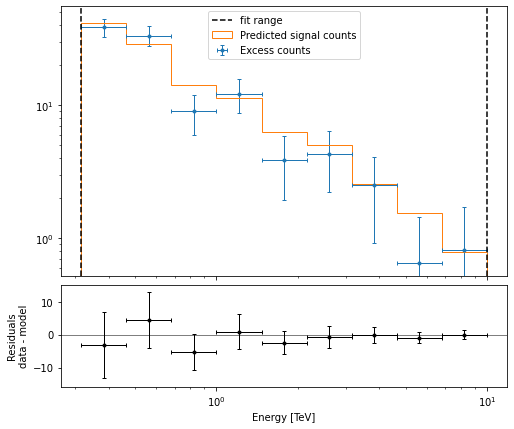

In [100]:
dataset.plot_fit()

Text(0.5, 1.0, 'diff/sqrt(model)')

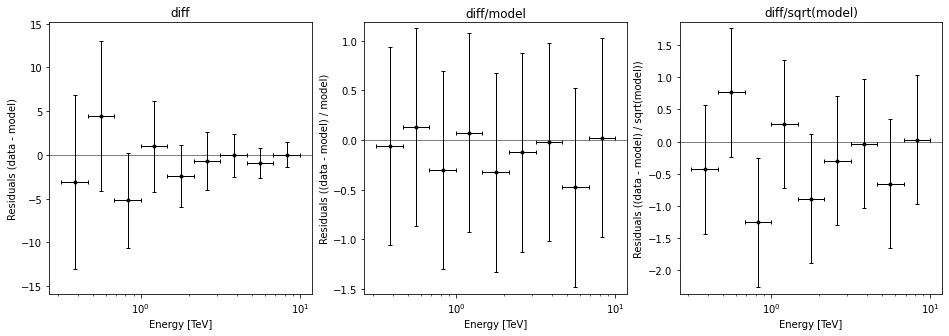

In [101]:

plt.figure(figsize=(16,5))

ax1 = plt.subplot(131)
dataset.plot_residuals_spectral(method='diff', ax=ax1)
ax1.set_title('diff')

ax2 = plt.subplot(132)
dataset.plot_residuals_spectral(method='diff/model', ax=ax2)
ax2.set_title('diff/model')

ax3 = plt.subplot(133)
dataset.plot_residuals_spectral(method='diff/sqrt(model)', ax=ax3)
ax3.set_title('diff/sqrt(model)')


## 1. Plot without error

In [105]:
def plot_residuals_spectral(self, ax=None, method="diff", region=None, **kwargs):
    
        counts, npred = self.counts.copy(), self.npred()

        if self.mask is not None:
            counts *= self.mask
            npred *= self.mask

        counts_spec = counts.get_spectrum(region)
        npred_spec = npred.get_spectrum(region)
        residuals = self._compute_residuals(counts_spec, npred_spec, method)

        if method == "diff":
            yerr = np.sqrt((counts_spec.data + npred_spec.data).flatten())
        #else:
            
        yerr = np.zeros_like(residuals.data.flatten())

        kwargs.setdefault("color", kwargs.pop("c", "black"))
        ax = residuals.plot(ax, yerr=yerr, **kwargs)
        ax.axhline(0, color=kwargs["color"], lw=0.5)

        label = self._residuals_labels[method]
        ax.set_ylabel(f"Residuals ({label})")
        ax.set_yscale("linear")
        ymin = 1.05 * np.nanmin(residuals.data - yerr)
        ymax = 1.05 * np.nanmax(residuals.data + yerr)
        ax.set_ylim(ymin, ymax)
        return ax

Text(0.5, 1.0, 'diff/sqrt(model)')

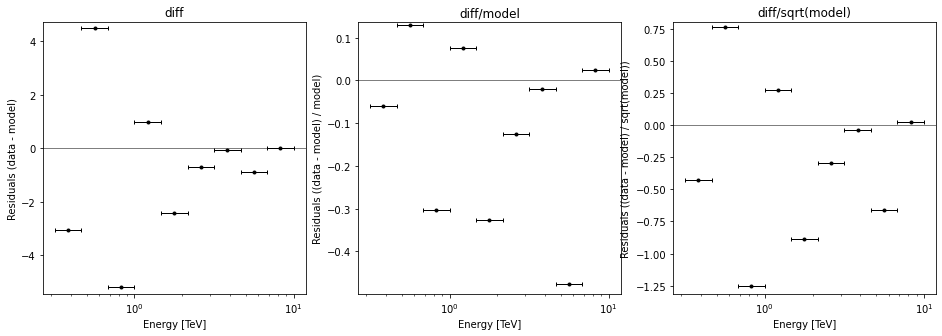

In [106]:
plt.figure(figsize=(16,5))

ax1 = plt.subplot(131)
plot_residuals_spectral(dataset, method='diff', ax=ax1)
ax1.set_title('diff')

ax2 = plt.subplot(132)
plot_residuals_spectral(dataset, method='diff/model', ax=ax2)
ax2.set_title('diff/model')

ax3 = plt.subplot(133)
plot_residuals_spectral(dataset, method='diff/sqrt(model)', ax=ax3)
ax3.set_title('diff/sqrt(model)')



## 2. Using CountStatistics

- different for OnOff and normal datasets
- smaller error bars than before
- only for the `diff` case

- What to do for `FluxPointDataset`?

In [108]:
from gammapy.stats import CashCountsStatistic, WStatCountsStatistic

In [110]:
cash = CashCountsStatistic(dataset.counts.data, dataset.npred().data)

<ErrorbarContainer object of 3 artists>

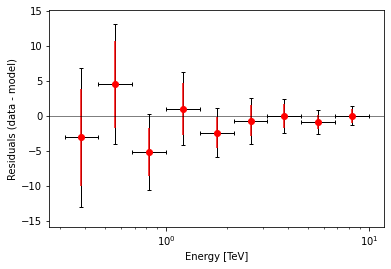

In [139]:

dataset.plot_residuals_spectral(method='diff')
plt.errorbar(energy_axis.center.value, 
             cash.n_sig.flatten(), 
             yerr=cash.error.flatten(),
            fmt='o', color='red')

## Using FluxPointEstimator

- Unnecessarily complicated
- more lines of code for the user (or, FluxPointEstimator is imported in Datasets)
- more intuitive for me to see the number of counts instead of flux

In [145]:
from gammapy.estimators import FluxPointsEstimator

In [148]:
%%time
fpe = FluxPointsEstimator(energy_edges=energy_axis.edges, source="source")
flux_points = fpe.run(datasets=[dataset])

CPU times: user 2.29 s, sys: 23.9 ms, total: 2.32 s
Wall time: 2.33 s


/Users/asinha/Gammapy-dev/gammapy/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/Users/asinha/Gammapy-dev/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/Users/asinha/Gammapy-dev/gammapy/gammapy/estimators/flux_point.py:742: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcol

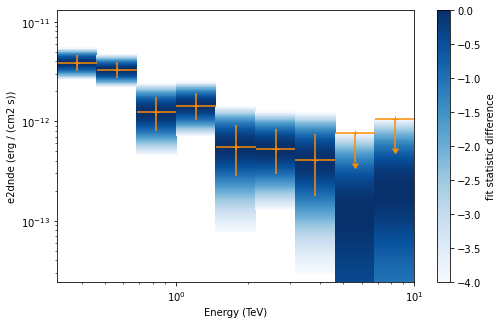

In [147]:
plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax);